In [1]:
import pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('9_NPL4_Sequence_Embeddings').getOrCreate()

file_location = "9_customers_behaviour.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
df = spark.read.format(file_type) \
 .option("inferSchema", infer_schema) \
 .option("header", first_row_is_header) \
 .option("sep", delimiter) \
 .load(file_location)
df.show(10,False)

22/10/29 14:20:29 WARN Utils: Your hostname, m0 resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
22/10/29 14:20:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/29 14:20:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------+-------------+--------------+------------+----------+
|user_id|page         |timestamp     |visit_number|time_spent|
+-------+-------------+--------------+------------+----------+
|cust01 |product info |8/20/2022 7:02|2           |0.152     |
|cust01 |reviews      |8/20/2022 7:03|3           |0.151     |
|cust01 |homepage     |8/20/2022 7:04|2           |0.182     |
|cust01 |product info |8/20/2022 7:05|3           |0.259     |
|cust01 |added to cart|8/20/2022 7:06|2           |0.127     |
|cust01 |product info |8/20/2022 7:07|1           |0.4352    |
|cust01 |homepage     |8/20/2022 7:08|2           |0.152     |
|cust01 |product info |8/20/2022 7:09|1           |0.185     |
|cust02 |product info |8/20/2022 7:12|1           |0.257     |
|cust02 |added to cart|8/20/2022 7:14|2           |0.875     |
+-------+-------------+--------------+------------+----------+
only showing top 10 rows



In [2]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- page: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- visit_number: string (nullable = true)
 |-- time_spent: string (nullable = true)



In [3]:
df.groupBy('page').count().orderBy('count',ascending=False).show(10,False)

+----------------+-----+
|page            |count|
+----------------+-----+
|product info    |59   |
|added to cart   |23   |
|reviews         |18   |
|buy             |10   |
|offers          |4    |
|homepage        |3    |
|product info+B40|1    |
+----------------+-----+



In [4]:
# Create an additional column that captures the previous page of the user
import pyspark.sql.functions as F
from pyspark.sql import Window
w = Window.partitionBy("user_id").orderBy('timestamp')
df = df.withColumn("previous_page",F.lag("page", 1, 'started').over(w))
df.select('user_id','timestamp','previous_page','page').show(10,False)

+-------+--------------+-------------+-------------+
|user_id|timestamp     |previous_page|page         |
+-------+--------------+-------------+-------------+
|cust01 |8/20/2022 7:02|started      |product info |
|cust01 |8/20/2022 7:03|product info |reviews      |
|cust01 |8/20/2022 7:04|reviews      |homepage     |
|cust01 |8/20/2022 7:05|homepage     |product info |
|cust01 |8/20/2022 7:06|product info |added to cart|
|cust01 |8/20/2022 7:07|added to cart|product info |
|cust01 |8/20/2022 7:08|product info |homepage     |
|cust01 |8/20/2022 7:09|homepage     |product info |
|cust01 |8/20/2022 8:06|product info |homepage     |
|cust01 |8/20/2022 8:07|homepage     |product info |
+-------+--------------+-------------+-------------+
only showing top 10 rows



In [5]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
def indicator(page, prev_page):
 if page == prev_page:
     return 0
 else:
     return 1
page_udf = udf(indicator,IntegerType())
df = df.withColumn("indicator",page_udf(F.col('page'),F.col('previous_page'))) \
                              .withColumn('indicator_cummulative',F.sum(F.col('indicator')).over(w))

In [6]:
# Create a function to check if the current page is like the previous page and
# indicate the same in a new column indicator. indicator_cumulative is the column to
# track the number of distinct pages during the user journey:
df.select('previous_page','page','indicator','indicator_cummulative').show(10,False)



+-------------+-------------+---------+---------------------+
|previous_page|page         |indicator|indicator_cummulative|
+-------------+-------------+---------+---------------------+
|started      |product info |1        |1                    |
|product info |reviews      |1        |2                    |
|reviews      |homepage     |1        |3                    |
|homepage     |product info |1        |4                    |
|product info |added to cart|1        |5                    |
|added to cart|product info |1        |6                    |
|product info |homepage     |1        |7                    |
|homepage     |product info |1        |8                    |
|product info |homepage     |1        |9                    |
|homepage     |product info |1        |10                   |
+-------------+-------------+---------+---------------------+
only showing top 10 rows



In [7]:
w2=Window.partitionBy(["user_id",'indicator_cummulative']).orderBy('timestamp')
df= df.withColumn('time_spent_cummulative',F.sum(F.col('time_spent')).over(w2))
df.select('timestamp','previous_page','page',
          'indicator','indicator_cummulative',
          'time_spent','time_spent_cummulative').show(20,False)

+--------------+----------------+----------------+---------+---------------------+----------+----------------------+
|timestamp     |previous_page   |page            |indicator|indicator_cummulative|time_spent|time_spent_cummulative|
+--------------+----------------+----------------+---------+---------------------+----------+----------------------+
|8/20/2022 7:02|started         |product info    |1        |1                    |0.152     |0.152                 |
|8/20/2022 7:03|product info    |reviews         |1        |2                    |0.151     |0.151                 |
|8/20/2022 7:04|reviews         |homepage        |1        |3                    |0.182     |0.182                 |
|8/20/2022 7:05|homepage        |product info    |1        |4                    |0.259     |0.259                 |
|8/20/2022 7:06|product info    |added to cart   |1        |5                    |0.127     |0.127                 |
|8/20/2022 7:07|added to cart   |product info    |1        |6   

In [8]:
# Calculate the aggregated time spent on similar pages so that
# only a single record can be kept for representing consecutive pages:
w3 =Window.partitionBy(["user_id",'indicator_cummulative']).orderBy(F.col('timestamp').desc())
df = df.withColumn('final_page',F.first('page').over(w3))\
 .withColumn('final_time_spent',F.first('time_spent_cummulative').
over(w3))
df.select(['time_spent_cummulative','indicator_cummulative',
           'page','final_page','final_time_spent']).show(10,False)

+----------------------+---------------------+-------------+-------------+----------------+
|time_spent_cummulative|indicator_cummulative|page         |final_page   |final_time_spent|
+----------------------+---------------------+-------------+-------------+----------------+
|0.152                 |1                    |product info |product info |0.152           |
|0.151                 |2                    |reviews      |reviews      |0.151           |
|0.182                 |3                    |homepage     |homepage     |0.182           |
|0.259                 |4                    |product info |product info |0.259           |
|0.127                 |5                    |added to cart|added to cart|0.127           |
|0.4352                |6                    |product info |product info |0.4352          |
|0.152                 |7                    |homepage     |homepage     |0.152           |
|0.185                 |8                    |product info |product info |0.185 

In [9]:
aggregations = []
aggregations.append(F.max(F.col('final_page')).alias('page_emb'))
aggregations.append(F.max(F.col('final_time_spent')).alias('time_spent_emb'))
df_embedding = df.select(['user_id','indicator_cummulative',
                          'final_page',
                          'final_time_spent']).groupBy(['user_id','indicator_cummulative']).agg(*aggregations)
w4 = Window.partitionBy(["user_id"]).orderBy('indicator_cummulative')
w5 = Window.partitionBy(["user_id"]).orderBy(F.col('indicator_cummulative').desc())

In [10]:
# Use collect list to combine all the pages of the user journey into a single
# list and for time spent as well. As a result, we end with a user journey in the form of a
# page list and time spent list:

df_embedding = df_embedding.withColumn('journey_page', F.collect_list(F.col('page_emb')).over(w4))\
 .withColumn('journey_time_temp', F.collect_list(F.col('time_spent_emb')).over(w4)) \
 .withColumn('journey_page_final',F.first('journey_page').over(w5))\
 .withColumn('journey_time_final',F.first('journey_time_temp').over(w5)) \
 .select(['user_id','journey_page_final','journey_time_final'])

In [11]:
# Each user is represented by a single journey and time spent vector:
df_embedding = df_embedding.dropDuplicates()
df_embedding.count()

8

In [12]:
df_embedding.select('user_id').distinct().count()

8

In [13]:
df_embedding.select('user_id','journey_page_final','journey_time_final').show(10,False)

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|journey_page_final                                                                                                                                                                                                                   |journey_time_final                                                                                                                                            |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
# Move to create embeddings using the word2vec model by feeding it the
# user journey sequence. The embedding size is kept to 100 for this part:
from pyspark.ml.feature import Word2Vec
word2vec = Word2Vec(vectorSize = 100, inputCol = 'journey_page_final', outputCol = 'embedding')
model = word2vec.fit(df_embedding)
result = model.transform(df_embedding)
result.show(10)

22/10/29 14:21:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/29 14:21:33 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


+-------+--------------------+--------------------+--------------------+
|user_id|  journey_page_final|  journey_time_final|           embedding|
+-------+--------------------+--------------------+--------------------+
| cust01|[product info, re...|[0.152, 0.151, 0....|[6.71888026408851...|
| cust02|[product info, ad...|[0.257, 0.875, 1....|[7.56521954348212...|
| cust03|[added to cart, r...|[2.032, 1.6759999...|[-3.7545792292803...|
| cust04|[added to cart, p...|[2.625, 3.4530000...|[0.00179694201797...|
| cust05|[added to cart, p...|[0.875, 1.151, 1....|[0.00263937227427...|
| cust06|[added to cart, p...|[0.257, 0.7030000...|[8.30266779909531...|
| cust07|[product info, ad...|[6.264, 0.257, 0....|[0.00199543808897...|
| cust08|[product info, re...|[0.45, 1.41699999...|[6.37046624130258...|
+-------+--------------------+--------------------+--------------------+



In [15]:
# extract embeddings for each page category using getVectors(), but do ensure
# to change the datatype of the embeddings to double as the embeddings’ original format
# is vector in Spark:
embeddings=model.getVectors()
embeddings.printSchema()

root
 |-- word: string (nullable = true)
 |-- vector: vector (nullable = true)



In [16]:
from pyspark.ml.functions import vector_to_array
embeddings=embeddings.withColumn('vector',vector_to_array('vector'))
embeddings.printSchema()

root
 |-- word: string (nullable = true)
 |-- vector: array (nullable = false)
 |    |-- element: double (containsNull = false)



In [17]:
embeddings.show(10)

+-------------+--------------------+
|         word|              vector|
+-------------+--------------------+
| product info|[0.00149395922198...|
|added to cart|[0.00299839582294...|
|      reviews|[-0.0037493116687...|
|          buy|[0.00421215128153...|
+-------------+--------------------+



In [22]:
page_categories=embeddings.select('word').distinct().collect()
unique_pages = [i.word for i in page_categories]
print(unique_pages)
# As we can observe, the vocabulary size is 5 because we were dealing with seven page
# categories only. Each of these page categories now can be represented with the help of
# the embedding vector of size 100:

['buy', 'product info', 'reviews', 'added to cart']


In [25]:
# In order to visualize the embeddings of each of the page categories, we can convert
# the embeddings Dataframe to a Pandas Dataframe and later use matplotlib to plot the
# embeddings:
pd_df_embedding = embeddings.toPandas()
pd_df_embedding

,word,vector
0,product info,"[0.0014939592219889164, -0.0016705667367205024..."
1,added to cart,"[0.002998395822942257, 0.0010963422246277332, ..."
2,reviews,"[-0.0037493116687983274, 0.0031501781195402145..."
3,buy,"[0.0042121512815356255, -0.0041915178298950195..."


In [27]:
import pandas as pd
X=pd.DataFrame(pd_df_embedding['vector'].values.tolist())
X.shape
X.head(3)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.001494,-0.001671,-0.004440,-0.003140,-0.001053,0.002440,-0.002817,-0.003006,0.000227,0.000485,...,-0.002403,0.000714,-0.002166,0.002788,-0.003274,0.002558,-0.004752,0.001555,0.003789,-0.001598
1,0.002998,0.001096,-0.000031,0.001262,0.003328,0.000145,-0.001511,0.002427,0.001958,0.001462,...,-0.003948,0.000401,-0.000105,-0.001644,-0.001139,0.004247,-0.004210,-0.001851,-0.002642,-0.001710
2,-0.003749,0.003150,-0.004214,-0.003216,-0.000057,0.002436,-0.004245,-0.004828,0.003866,0.001452,...,-0.004661,0.003624,-0.000494,0.000232,0.000066,-0.000355,0.002831,-0.000174,0.002811,0.002471


In [28]:
# In order to better understand the relation between these page categories, we can use
# the dimensionality reduction technique (PCA) and plot these seven page embeddings
# on a two-dimensional space:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_df = pca.fit_transform(X)
pca_df

array([[-0.01397963,  0.02140264],
       [-0.01403992, -0.0125632 ],
       [ 0.0021821 , -0.01484667],
       [ 0.02583745,  0.00600723]])

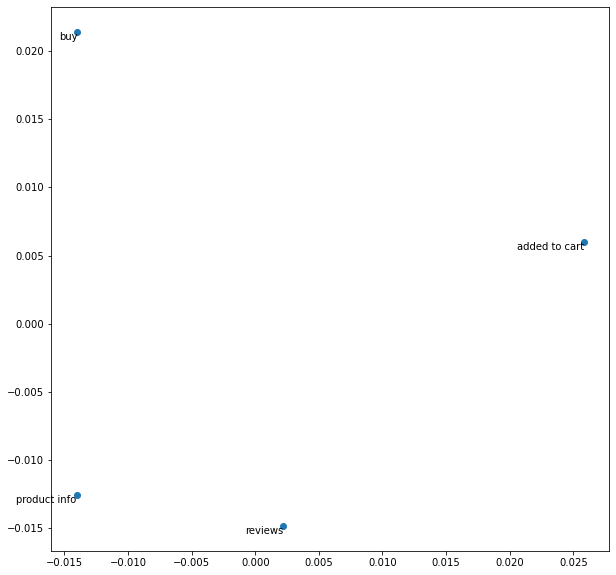

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.scatter(pca_df[:, 0], pca_df[:, 1])
for i,unique_page in enumerate(unique_pages):
    plt.annotate(unique_page,horizontalalignment='right',
                 verticalalignment='top',
                 xy=(pca_df[i, 0], 
                     pca_df[i, 1]))
plt.show()